# 第7章 決定木

## 7.1 回帰の決定木

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from numpy.random import randn  #正規乱数

/home/yuma/.cache/pypoetry/virtualenvs/statistical-learning-with-python-gf79ENdJ-py3.6/lib/python3.6/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
def sq_loss(y):
    if len(y) == 0:
        return (0)
    else:
        y_bar = np.mean(y)
        return (np.linalg.norm(y - y_bar)**2)

In [3]:
def branch(x, y, S, rf=0):
    if rf == 0:
        m = x.shape[1]
    if x.shape[0] == 0:
        return ([0, 0, 0, 0, 0, 0, 0])
    best_score = np.inf
    for j in range(x.shape[1]):
        for i in S:
            left = []
            right = []
            for k in S:
                if x[k, j] < x[i, j]:
                    left.append(k)
                else:
                    right.append(k)
            left_score = f(y[left])
            right_score = f(y[right])
            score = left_score + right_score
            if score < best_score:
                best_score = score
                i_1 = i
                j_1 = j
                left_1 = left
                right_1 = right
                left_score_1 = left_score
                right_score_1 = right_score
    return [i_1, j_1, left_1, right_1, best_score, left_score_1, right_score_1]

In [4]:
class Stack:
    def __init__(self, parent, set, score):
        self.parent = parent
        self.set = set
        self.score = score

In [5]:
class Node:
    def __init__(self, parent, j, th, set):
        self.parent = parent
        self.j = j
        self.th = th
        self.set = set

In [6]:
def dt(x, y, alpha=0, n_min=1, rf=0):
    if rf == 0:
        m = x.shape[1]
    # 1個からなるstackを構成。決定木を初期化
    stack = [Stack(0, list(range(x.shape[0])), f(y))]  # 関数 fは、大域
    node = []
    k = -1
    # stackの最後の要素を取り出して、決定木を更新する。
    while len(stack) > 0:
        popped = stack.pop()
        k = k + 1
        i, j, left, right, score, left_score, right_score = branch(
            x, y, popped.set, rf)
        if popped.score - score < alpha or len(
                popped.set) < n_min or len(left) == 0 or len(right) == 0:
            node.append(Node(popped.parent, -1, 0, popped.set))
        else:
            node.append(Node(popped.parent, j, x[i, j], popped.set))
            stack.append(Stack(k, right, right_score))
            stack.append(Stack(k, left, left_score))
    # これより下でnode.left, node.rightの値を設定する
    for h in range(k, -1, -1):
        node[h].left = 0
        node[h].right = 0
    for h in range(k, 0, -1):
        pa = node[h].parent
        if node[pa].right == 0:
            node[pa].right = h
        else:
            node[pa].left = h
    # これより下で、node.centerの値を計算する
    if f == sq_loss:
        g = np.mean
    else:
        g = mode_max
    for h in range(k + 1):
        if node[h].j == -1:
            node[h].center = g(y[node[h].set])
        else:
            node[h].center = 0
    return (node)

In [7]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target
f = sq_loss
node = dt(X, y, n_min=50)
len(node)

37

In [8]:
import igraph as ig

In [9]:
r = len(node)
edge = []
for h in range(1, r):
    edge.append([node[h].parent, h])

In [10]:
TAB = []
for h in range(r):
    if not node[h].j == 0:
        TAB.append([h, node[h].j, node[h].th])
TAB

[[0, 5, 6.943],
 [1, 12, 14.43],
 [2, 7, 1.413],
 [3, -1, 0],
 [4, 5, 6.546],
 [5, 12, 7.6],
 [6, -1, 0],
 [7, 9, 223.0],
 [8, -1, 0],
 [9, 5, 6.083],
 [10, 6, 69.5],
 [11, 7, 4.4986],
 [12, -1, 0],
 [13, -1, 0],
 [14, -1, 0],
 [15, 12, 10.15],
 [16, -1, 0],
 [17, -1, 0],
 [18, 9, 273.0],
 [19, -1, 0],
 [20, -1, 0],
 [22, 4, 0.538],
 [23, -1, 0],
 [24, 12, 19.01],
 [25, 6, 85.7],
 [26, -1, 0],
 [27, -1, 0],
 [28, -1, 0],
 [29, 4, 0.614],
 [30, -1, 0],
 [31, 12, 19.77],
 [32, -1, 0],
 [33, -1, 0],
 [34, 5, 7.454],
 [35, -1, 0],
 [36, -1, 0]]

In [11]:
def draw_graph(node):
    r = len(node)
    col = []
    for h in range(r):
        col.append(node[h].j)
    colorlist = [
        '#ffffff', '#fff8ff', '#fcf9ce', '#d6fada', '#d7ffff', '#d9f2f8',
        '#fac8be', '#ffebff', '#ffffe0', '#fdf5e6', '#fac8be', '#f8ecd5',
        '#ee82ee'
    ]
    color = [colorlist[col[i]] for i in range(r)]
    edge = []
    for h in range(1, r):
        edge.append([node[h].parent, h])
        g = ig.Graph(edges=edge, directed=True)
        layout = g.layout_reingold_tilford(root=[0])
    out = ig.plot(g,
                  vertex_size=15,
                  layout=layout,
                  bbox=(300, 300),
                  vertex_label=list(range(r)),
                  vertex_color=color)
    return (out)

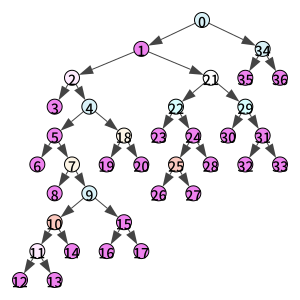

In [12]:
draw_graph(node)

In [13]:
def value(u, node):
    r = 0
    while node[r].j != -1:
        if u[node[r].j] < node[r].th:
            r = node[r].left
        else:
            r = node[r].right
    return (node[r].center)

11.2123
11.169741666666662
11.138088888888886
11.073173611111109
10.98831805555555
10.918474305555554
10.923048228458047
10.894865589569157
10.970726006235825
11.051589873456788
11.008887095679011
10.790952453955654
10.788552453955653
10.975752453955657
10.972330231733434


Text(0.5, 1.0, 'CVで最適なalpha (N=100)')

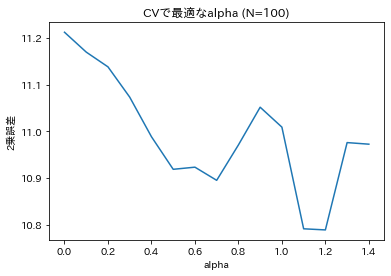

In [14]:
from sklearn.datasets import load_boston
boston = load_boston()
n = 100
X = boston.data[range(n), :]
y = boston.target[range(n)]
f = sq_loss
alpha_seq = np.arange(0, 1.5, 0.1)
s = np.int(n / 10)
out = []
for alpha in alpha_seq:
    SS = 0
    for h in range(10):
        test = list(range(h * s, h * s + s))
        train = list(set(range(n)) - set(test))
        node = dt(X[train, :], y[train], alpha=alpha)
        for t in test:
            SS = SS + (y[t] - value(X[t, :], node))**2
    print(SS / n)
    out.append(SS / n)
plt.plot(alpha_seq, out)
plt.xlabel('alpha')
plt.ylabel('2乗誤差')
plt.title("CVで最適なalpha (N=100)")

11.2123
11.2123
11.160350000000001
10.779608333333336
10.974831944444444
10.776290444444447
10.778481666666671
10.686344513038552
10.585849200538545
11.914784839238472
12.298008067255603
12.478392363347837


Text(0.5, 1.0, 'CVで最適なn_min (N=100)')

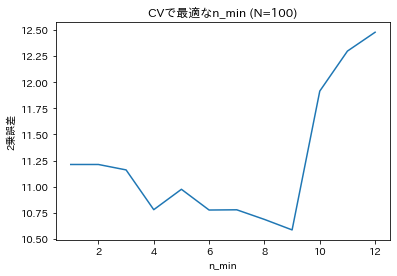

In [15]:
from sklearn.datasets import load_boston
boston = load_boston()
n = 100
X = boston.data[range(n), :]
y = boston.target[range(n)]
n_min_seq = np.arange(1, 13, 1)
s = np.int(n / 10)
out = []
for n_min in n_min_seq:
    SS = 0
    for h in range(10):
        test = list(range(h * s, h * s + s))
        train = list(set(range(n)) - set(test))
        node = dt(X[train, :], y[train], n_min=n_min)
        for t in test:
            SS = SS + (y[t] - value(X[t, :], node))**2
    print(SS / n)
    out.append(SS / n)
plt.plot(n_min_seq, out)
plt.xlabel('n_min')
plt.ylabel('2乗誤差')
plt.title("CVで最適なn_min (N=100)")

# 7.2 分類の決定木

In [16]:
def freq(y):
    y = list(y)
    return ([y.count(i) for i in set(y)])

In [17]:
# モード(最頻度)
def mode(y):
    n = len(y)
    if n == 0:
        return (0)
    return (max(freq(y)))

In [18]:
# 誤り率
def mis_match(y):
    return (len(y) - mode(y))

In [19]:
# Gini
def gini(y):
    n = len(y)
    if n == 0:
        return (0)
    fr = freq(y)
    return (sum([fr[i] * (n - fr[i]) for i in range(len(fr))]))

In [20]:
# Entropy
def entropy(y):
    n = len(y)
    if n == 0:
        return (0)
    freq = [y.count(i) for i in set(y)]
    return (np.sum([-freq[i] * np.log(freq[i] / n) for i in range(len(freq))]))

In [21]:
def table_count(m, u, v):  # 再掲
    n = u.shape[0]
    count = np.zeros([m, m])
    for i in range(n):
        count[int(u[i]), int(v[i])] += 1
    return (count)

In [22]:
def mode_max(y):
    if len(y) == 0:
        return (-np.inf)
    count = np.bincount(y)
    return (np.argmax(count))

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.target_names
f = mis_match
n = iris.data.shape[0]
x = iris.data
y = iris.target
n = len(x)
node = dt(x, y, n_min=4)
m = len(node)
u = []
v = []
for h in range(m):
    if node[h].j == -1:
        w = y[node[h].set]
        u.extend([node[h].center] * len(w))
        v.extend(w)
table_count(3, np.array(u), np.array(v))
#sum([u[i]==v[i] for i in range(150)])

array([[50.,  0.,  0.],
       [ 0., 48.,  0.],
       [ 0.,  2., 50.]])

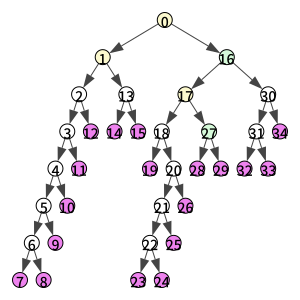

In [24]:
draw_graph(node)

In [25]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.target_names
f = mis_match
index = np.random.choice(n, n, replace=False)  # 並び替える
X = iris.data[index, :]
y = iris.target[index]
n_min_seq = np.arange(5, 51, 5)
s = 15
for n_min in n_min_seq:
    SS = 0
    for h in range(10):
        test = list(range(h * s, h * s + s))
        train = list(set(range(n)) - set(test))
        node = dt(X[train, :], y[train], n_min=n_min)
        for t in test:
            SS = SS + np.sum(y[t] != value(X[t, :], node))
    print(SS / n)

0.07333333333333333
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.07333333333333333
0.08
0.08
0.08666666666666667
0.1


## 7.3 バギング

In [26]:
n = 200
p = 5
X = np.random.randn(n, p)
beta = randn(p)
Y = np.array(np.abs(np.dot(X, beta) + randn(n)), dtype=np.int64)
f = mis_match

In [27]:
node_seq = []
for h in range(8):
    index = np.random.choice(n, n, replace=True)  # 並び替える
    x = X[index, :]
    y = Y[index]
    node_seq.append(dt(x, y, n_min=6))

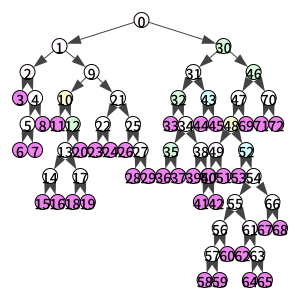

In [28]:
draw_graph(node_seq[0])

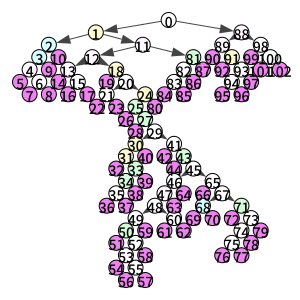

In [29]:
draw_graph(node_seq[1])

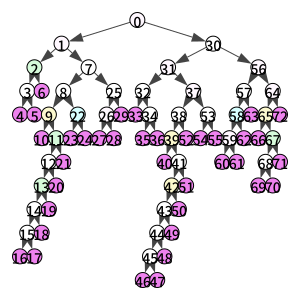

In [30]:
draw_graph(node_seq[2])

In [31]:
def branch(x, y, S, rf=0):  ##
    if rf == 0:  ##
        T = np.arange(x.shape[1])  ##
    else:  ##
        T = np.random.choice(x.shape[1], rf, replace=False)  ##
    if x.shape[0] == 0:
        return ([0, 0, 0, 0, 0, 0, 0])
    best_score = np.inf
    for j in T:  ##
        for i in S:
            left = []
            right = []
            for k in S:
                if x[k, j] < x[i, j]:
                    left.append(k)
                else:
                    right.append(k)
            left_score = f(y[left])
            right_score = f(y[right])
            score = left_score + right_score
            if score < best_score:
                best_score = score
                i_1 = i
                j_1 = j
                left_1 = left
                right_1 = right
                left_score_1 = left_score
                right_score_1 = right_score
    return [i_1, j_1, left_1, right_1, best_score, left_score_1, right_score_1]

## 7.4 ランダムフォレスト

In [32]:
def rf(z):
    z = np.array(z, dtype=np.int64)
    zz = []
    for b in range(B):
        u = sum(
            [mode_max(z[range(b + 1), i]) == y[i + 100] for i in range(50)])
        zz.append(u)
    return (zz)

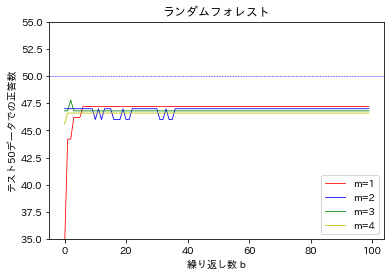

In [33]:
iris = load_iris()
iris.target_names
f = mis_match
n = iris.data.shape[0]
order = np.random.choice(n, n, replace=False)  # 並び替える
X = iris.data[order, :]
y = iris.target[order]
train = list(range(100))
test = list(range(100, 150))
B = 100
plt.ylim([35, 55])
m_seq = [1, 2, 3, 4]
c_seq = ["r", "b", "g", "y"]
label_seq = ['m=1', 'm=2', 'm=3', 'm=4']
plt.xlabel('繰り返し数 b')
plt.ylabel('テスト50データでの正答数')
plt.title('ランダムフォレスト')
for m in m_seq:
    z = np.zeros((B, 50))
    for b in range(B):
        index = np.random.choice(train, 100, replace=True)
        node = dt(X[index, :], y[index], n_min=2, rf=m)
        for i in test:
            z[b, i - 100] = value(X[i, ], node)
    plt.plot(list(range(B)),
             np.array(rf(z)) - 0.2 * (m - 2),
             label=label_seq[m - 1],
             linewidth=0.8,
             c=c_seq[m - 1])
plt.legend(loc='lower right')
plt.axhline(y=50, c="b", linewidth=0.5, linestyle="dashed")

## 7.5 ブーステイング

In [34]:
def b_dt(x, y, d):
    n = x.shape[0]
    node = []
    first = Node(0, -1, 0, np.arange(n))
    first.score = f(y[first.set])
    node.append(first)
    while len(node) <= 2 * d - 1:
        r = len(node)
        gain_max = -np.inf
        for h in range(r):
            if node[h].j == -1:
                i, j, left, right, score, left_score, right_score = branch(
                    x, y, node[h].set)
                gain = node[h].score - score
                if gain > gain_max:
                    gain_max = gain
                    h_max = h
                    i_0 = i
                    j_0 = j
                    left_0 = left
                    right_0 = right
                    left_score_0 = left_score
                    right_score_0 = right_score
        node[h_max].th = x[i_0, j_0]
        node[h_max].j = j_0
        next = Node(h_max, -1, 0, left_0)
        next.score = f(y[next.set])
        node.append(next)
        next = Node(h_max, -1, 0, right_0)
        next.score = f(y[next.set])
        node.append(next)
    r = 2 * d + 1
    for h in range(r):
        node[h].left = 0
        node[h].right = 0
    for h in range(r - 1, 1, -1):
        pa = node[h].parent
        if node[pa].right == 0:
            node[pa].right = h
        else:
            node[pa].left = h
        if node[h].right == 0 and node[h].left == 0:
            node[h].j = -1
    if f == sq_loss:
        g = np.mean
    else:
        g = mode_max
    for h in range(r):
        if node[h].j == -1:
            node[h].center = g(node[h].set)
# これより下でnode.left, node.rightの値を設定する
    for h in range(r - 1, -1, -1):
        node[h].left = 0
        node[h].right = 0
    for h in range(r - 1, 0, -1):
        pa = node[h].parent
        if node[pa].right == 0:
            node[pa].right = h
        else:
            node[pa].left = h


# これより下で、node.centerの値を計算する
    if f == sq_loss:
        g = np.mean
    else:
        g = mode_max
    for h in range(r):
        if node[h].j == -1:
            node[h].center = g(y[node[h].set])
        else:
            node[h].center = 0
    return (node)

In [35]:
from sklearn.datasets import load_boston
boston = load_boston()
B = 200
lam = 0.1
X = boston.data
y = boston.target
f = sq_loss
train = list(range(200))
test = list(range(200, 300))
# ブースティングの木をB個生成
# 各dで5分程度、合計15分程度かかります
trees_set = []
for d in range(1, 4):
    trees = []
    r = y[train]
    for b in range(B):
        trees.append(b_dt(X[train, :], r, d))
        for i in train:
            r[i] = r[i] - lam * value(X[i, :], trees[b])
        print(b)
    trees_set.append(trees)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


In [36]:
# テストデータで評価
out_set = []
for d in range(1, 4):
    trees = trees_set[d - 1]
    z = np.zeros((B, 600))
    for i in test:
        z[0, i] = lam * value(X[i, ], trees[0])
        for b in range(1, B):
            for i in test:
                z[b, i] = z[b - 1, i] + lam * value(X[i, :], trees[b])
    out = []
    for b in range(B):
        out.append(sum((y[test] - z[b, test])**2) / len(test))
    out_set.append(out)

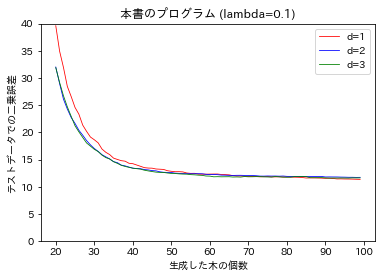

In [37]:
# グラフで表示
plt.ylim([0, 40])
c_seq = ["r", "b", "g"]
label_seq = ['d=1', 'd=2', 'd=3']
plt.xlabel('生成した木の個数')
plt.ylabel('テストデータでの二乗誤差')
plt.title('本書のプログラム (lambda=0.1)')
for d in range(1, 4):
    out = out_set[d - 1]
    u = range(20, 100)
    v = out[20:100]
    plt.plot(u, v, label=label_seq[d - 1], linewidth=0.8, c=c_seq[d - 1])
plt.legend(loc='upper right')

In [38]:
import lightgbm as lgb
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target
train = list(range(200))
test = list(range(200, 300))
B = 200
lgb_train = lgb.Dataset(X[train, :], y[train])
lgb_eval = lgb.Dataset(X[test, :], y[test], reference=lgb_train)

B = 5000
nn_seq = list(range(1, 10, 1)) + list(range(10, 91, 10)) + list(
    range(100, B, 50))
out_set = []
for d in range(1, 4):
    lgbm_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': d + 1,
        'learning_rate': 0.001
    }
    out = []
    for nn in nn_seq:
        model = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          verbose_eval=False,
                          num_boost_round=nn)
        z = model.predict(X[test, :], num_iteration=model.best_iteration)
        out.append(sum((z - y[test])**2) / 100)
    out_set.append(out)

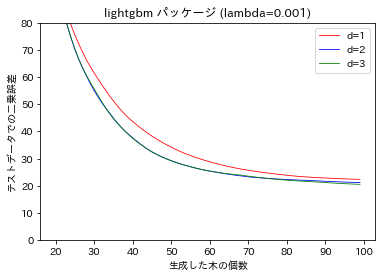

In [39]:
# グラフで表示
plt.ylim([0, 80])
c_seq = ["r", "b", "g"]
label_seq = ['d=1', 'd=2', 'd=3']
plt.xlabel('生成した木の個数')
plt.ylabel('テストデータでの二乗誤差')
plt.title('lightgbm パッケージ (lambda=0.001)')
for d in range(1, 4):
    out = out_set[d - 1]
    u = range(20, 100)
    v = out[20:100]
    plt.plot(u, v, label=label_seq[d - 1], linewidth=0.8, c=c_seq[d - 1])
plt.legend(loc='upper right')

In [40]:
f = sq_loss
n = 100
p = 5
x = randn(n, p)
y = randn(n)
S = np.random.choice(n, 10, replace=False)
branch(x, y, S)

[30,
 1,
 [51, 95, 28, 89, 45, 79, 31, 80, 7],
 [30],
 4.011266233632832,
 4.011266233632832,
 0.0]